In [0]:
# importing the same old libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tqdm import tqdm_notebook # Creates Progress bars
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import os
print(os.listdir("../input"))

['digit-recognizer']


In [0]:
# importing the new libraries , the ones required for implementing pytorch framework in our model

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim

In [0]:
# importing the dataset
df=pd.read_csv("../input/digit-recognizer/train.csv")

In [0]:
df.shape

(42000, 785)

**Data Preprocessing**

In [0]:
# Converting to numpy array
X=df.iloc[:,1:].values
Y=df.iloc[:,0].values

In [0]:
print(X.shape)
print(Y.shape)

(42000, 784)
(42000,)


In [0]:
df.iloc[:,0].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [0]:
# Splitting into Training and Validation datasets 

from sklearn.model_selection import train_test_split
X_train,X_val,Y_train,Y_val=train_test_split(X,Y,test_size=0.2,stratify=Y,random_state=0)
print(X_train.shape,X_val.shape,Y_train.shape,Y_val.shape)

(33600, 784) (8400, 784) (33600,) (8400,)


In [0]:
# StandardScaling the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)

In [0]:
# Converting Numpy arrays to Pytorch Tensors after applying scaling
X_train,X_val,Y_train,Y_val = map(torch.tensor,(X_train,X_val,Y_train,Y_val))

In [0]:
print(type(X_train),type(Y_train),type(X_val),type(Y_val)) # X_train and company are now tensors

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


**Writing the class Feedforward Networks**

In [0]:
class FFNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.net= nn.Sequential(nn.Linear(784,32),nn.Sigmoid(),nn.Linear(32,16),nn.Sigmoid(),nn.Linear(16,10),nn.Softmax())
        
    def forward(self,X):
        return self.net(X)

In [0]:
def accuracy(y_hat, y):
  pred = torch.argmax(y_hat, dim=1)
  return (pred == y).float().mean()

In [0]:
def fit(x, y, model, l_r, epochs=1000):
    loss_arr=[]
    acc_arr=[]
    opt=optim.Adamax(fn.parameters(),lr= l_r)
    for epochs in range(epochs):
        y_hat=fn(x.float())
        loss=F.cross_entropy(y_hat, y)
        loss_arr.append(loss.item())
        acc_arr.append(accuracy(y_hat, y))
        loss.backward()
        opt.step()
        opt.zero_grad()
    plt.plot(loss_arr, 'r')
    plt.plot(acc_arr,'b')
    plt.show()
    print('Loss before training', loss_arr[0])
    print('Loss after training', loss_arr[-1])
    print('Accuracy', acc_arr[-1])

In [0]:
#Taking data to GPU
device = torch.device("cuda")

X_train=X_train.to(device)
Y_train=Y_train.to(device)
X_val=X_val.to(device)
Y_val=Y_val.to(device)

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


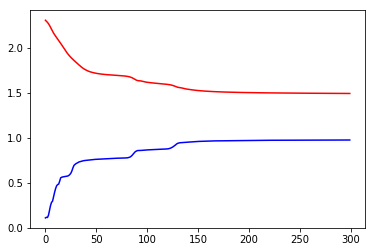

Loss before training 2.3024728298187256
Loss after training 1.4908323287963867
Accuracy tensor(0.9750, device='cuda:0')
Test accuracy: tensor(0.9126, device='cuda:0')


In [0]:
fn = FFNetwork()
fn.to(device)
fit(X_train, Y_train, fn, l_r= 0.05, epochs=300)
print("Test accuracy:",accuracy(fn(X_val.float()), Y_val))

**Applying our Model to test data for submission to Kaggle**

In [0]:
df_test=pd.read_csv("../input/digit-recognizer/test.csv")
X_test=df_test.values
X_test=sc.transform(X_test)
X_test=torch.from_numpy(X_test).to(device)# X_test is now a cuda tensor

In [0]:
Y_pred_test=fn(X_test.float())
Y_pred_test = torch.argmax(Y_pred_test, dim=1)

submission = {}
submission['ImageId'] = np.array(range(1,X_test.shape[0]+1))
submission['Label'] = Y_pred_test.cpu()

submission = pd.DataFrame(submission)
submission = submission[['ImageId', 'Label']]
submission = submission.sort_values(['ImageId'])
submission.to_csv("submisision.csv", index=False)